In [1]:
# Simulate dataset and run ARIMA, SARIMA, Holt-Winters for one student (Forecast B: next 3 semesters)
# This will produce plots and a comparison table.
# Requirements: pandas, numpy, matplotlib, statsmodels, scikit-learn, (optional pmdarima)
# The execution environment already provides plotting output to you.
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Optional auto_arima
HAS_PMD = False
try:
    from pmdarima import auto_arima
    HAS_PMD = True
except Exception:
    HAS_PMD = False

# Helper functions
def evaluate_forecast(true, pred):
    true_vals = np.array(true)
    pred_vals = np.array(pred)
    mse = mean_squared_error(true_vals, pred_vals)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(true_vals, pred_vals)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((true_vals - pred_vals) / true_vals)) * 100
    return {'rmse':rmse, 'mae':mae, 'mape':mape}

def safe_plot_acf(resid, ax=None, max_lags=12):
    import matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()
    resid = resid.dropna()
    if len(resid) > 3:
        lags = min(max_lags, len(resid) - 1)
        sm.graphics.tsa.plot_acf(resid, lags=lags, ax=ax)
    else:
        ax.text(0.5, 0.5, "Not enough residuals to compute ACF", ha='center', va='center')
        ax.axis('off')



In [3]:
# 1) Simulate dataset (500 students, Years 2020-2025, 3 semesters per year)
np.random.seed(42)
students = list(range(1001, 1001+500))  # Student IDs 1001..1500
years = list(range(2020, 2026))  # 2020..2025 inclusive
semesters = ['Spring', 'Summer', 'Fall']

rows = []
for sid in students:
    # each student has a base ability level
    base = np.clip(np.random.normal(3.0, 0.3), 0.0, 4.0)  # GPA mean around 3.0
    trend = np.random.normal(0.0, 0.02)  # small trend per semester
    noise_scale = np.random.uniform(0.05, 0.2)
    t = 0
    for y in years:
        for sem in semesters:
            # GPA evolves with slight trend + seasonal effect per semester + noise
            season_effect = {'Spring': 0.03, 'Summer': -0.02, 'Fall': 0.00}[sem]
            gpa = base + trend * t + season_effect + np.random.normal(0, noise_scale)
            gpa = np.clip(gpa, 0.0, 4.0)
            rows.append({'studentID': sid, 'Year': y, 'Semester': sem, 'GPA': round(gpa, 3)})
            t += 1

df = pd.DataFrame(rows)

# Quick check
print("Simulated dataset shape:", df.shape)
df.to_csv("student_gpa.csv", index=False)
print(df.head())



Simulated dataset shape: (9000, 4)


PermissionError: [Errno 13] Permission denied: 'student_gpa.csv'


Selected studentID: 1001

Time series length (periods): 18
date
2020-03-01    3.001
2020-07-01    3.177
2020-11-01    3.188
2021-03-01    3.332
2021-07-01    3.025
2021-11-01    3.051
2022-03-01    3.071
2022-07-01    2.962
2022-11-01    2.709
2023-03-01    3.306
Name: GPA, dtype: float64


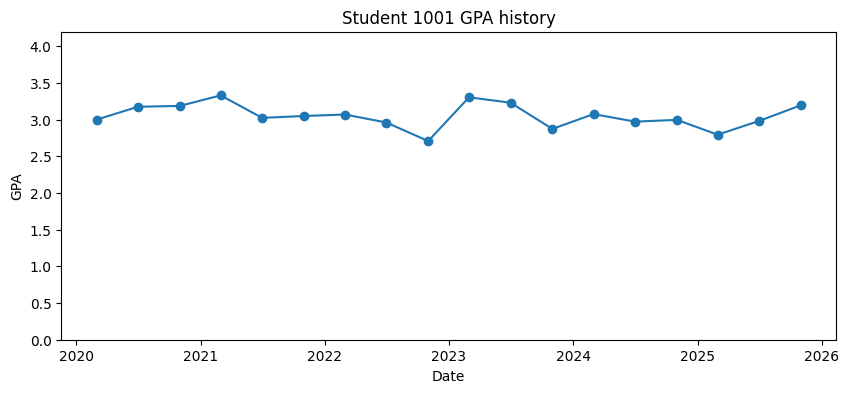

In [ ]:
# 2) Select Student 1 => as specified user asked "Student 1" meaning first student in dataset
student_id = df['studentID'].unique()[0]  # first student's ID (1001)
print("\nSelected studentID:", student_id)

df_student = df[df['studentID'] == student_id].copy().reset_index(drop=True)

# Map semester to month to build datetime index
semester_to_month = {'Spring': 3, 'Summer': 7, 'Fall': 11}
df_student['Month'] = df_student['Semester'].map(semester_to_month)
df_student['date'] = pd.to_datetime(dict(year=df_student['Year'].astype(int),
                                         month=df_student['Month'].astype(int),
                                         day=1))
df_student = df_student.sort_values('date').set_index('date')

# Build the time series of GPA
ts = df_student['GPA'].asfreq('QS-MAR')  # Quarterly anchored to March works for our chosen months
# If asfreq introduces NaNs (shouldn't here), fallback to plain series
if ts.isna().any():
    ts = df_student['GPA']

print("\nTime series length (periods):", len(ts))
print(ts.head(10))

# Plot the student's GPA history
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.values, marker='o')
plt.title(f"Student {student_id} GPA history")
plt.xlabel("Date")
plt.ylabel("GPA")
plt.ylim(0,4.2)
plt.grid(False)
plt.show()



In [ ]:
 #3) Train/Test split: reserve last 3 semesters as test (Forecast B: next 3 semesters horizon)
test_periods = 3
train = ts.iloc[:-test_periods]
test = ts.iloc[-test_periods:]
print("\nTrain periods:", len(train), "Test periods:", len(test))
print("Train last rows:\n", train.tail())
print("Test (held-out) rows:\n", test)




Train periods: 15 Test periods: 3
Train last rows:
 date
2023-07-01    3.232
2023-11-01    2.875
2024-03-01    3.077
2024-07-01    2.974
2024-11-01    2.998
Name: GPA, dtype: float64
Test (held-out) rows:
 date
2025-03-01    2.796
2025-07-01    2.984
2025-11-01    3.198
Name: GPA, dtype: float64



auto_arima suggested order: (0, 0, 0)

ARIMA fitted successfully.

ARIMA forecast (predicted mean):
 2025-03-01    3.065195
2025-07-01    3.065195
2025-11-01    3.065195
Freq: 4MS, Name: predicted_mean, dtype: float64


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)


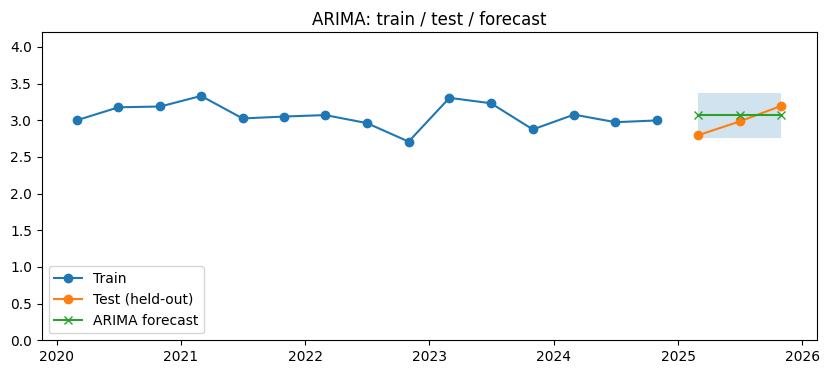

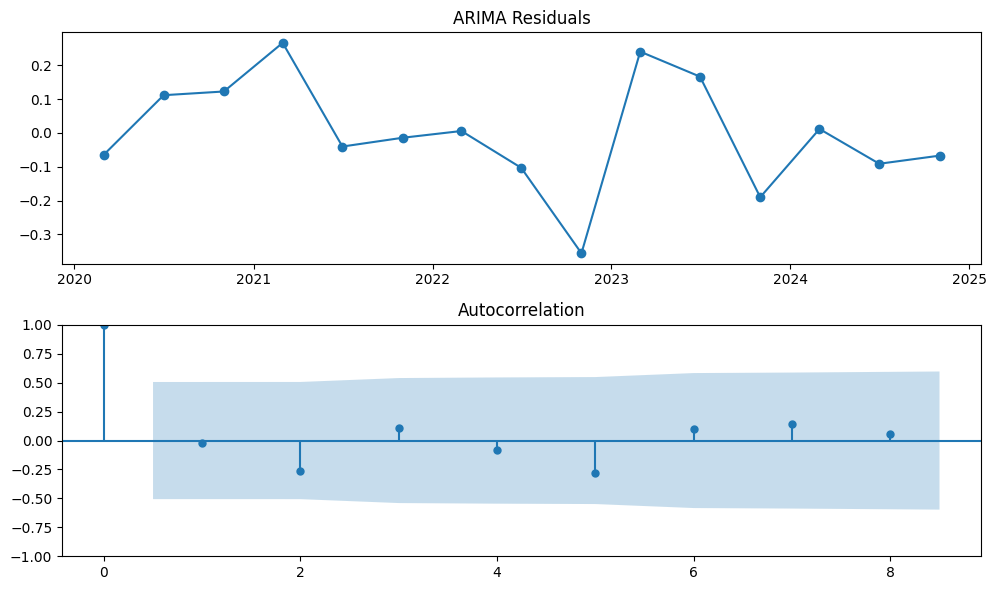

In [ ]:
# 4) ARIMA (non-seasonal) - try auto_arima if available, else default (1,1,1)
from statsmodels.tsa.arima.model import ARIMA

if HAS_PMD:
    try:
        auto = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=3, max_q=3)
        order_arima = auto.order
        print("\nauto_arima suggested order:", order_arima)
    except Exception as e:
        order_arima = (1,1,1)
        print("auto_arima failed, using default order (1,1,1). Error:", e)
else:
    order_arima = (1,1,1)
    print("\nUsing ARIMA order:", order_arima, "(p,d,q)")

# Fit ARIMA
try:
    model_arima = ARIMA(train, order=order_arima)
    res_arima = model_arima.fit()
    print("\nARIMA fitted successfully.")
except Exception as e:
    print("\nARIMA fitting failed:", e)
    res_arima = None

# Forecast with ARIMA
fc_arima = None
metrics_arima = {'rmse':np.nan, 'mae':np.nan, 'mape':np.nan}
if res_arima is not None:
    try:
        fc_arima = res_arima.get_forecast(steps=test_periods)
        pred_arima = fc_arima.predicted_mean
        metrics_arima = evaluate_forecast(test, pred_arima)
        print("\nARIMA forecast (predicted mean):\n", pred_arima)
    except Exception as e:
        print("ARIMA forecast failed:", e)
        fc_arima = None

# Plot ARIMA fit + forecast
plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, marker='o', label='Train')
plt.plot(test.index, test.values, marker='o', label='Test (held-out)')
if fc_arima is not None:
    try:
        plt.plot(pred_arima.index, pred_arima.values, marker='x', label='ARIMA forecast')
        ci = fc_arima.conf_int(alpha=0.05)
        plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
    except Exception:
        pass
plt.title("ARIMA: train / test / forecast")
plt.ylim(0,4.2)
plt.legend()
plt.show()

# ARIMA residual diagnostics (safe)
if res_arima is not None:
    resid = res_arima.resid.dropna()
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    plt.plot(resid.index, resid.values, marker='o')
    plt.title('ARIMA Residuals')
    plt.subplot(212)
    safe_plot_acf(resid, plt.gca(), max_lags=8)
    plt.tight_layout()
    plt.show()




auto_arima (seasonal) suggested: (0, 0, 0) (0, 1, 0, 3)

SARIMA fitted successfully.

SARIMA forecast:
 2025-03-01    3.077
2025-07-01    2.974
2025-11-01    2.998
Freq: 4MS, Name: predicted_mean, dtype: float64


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)


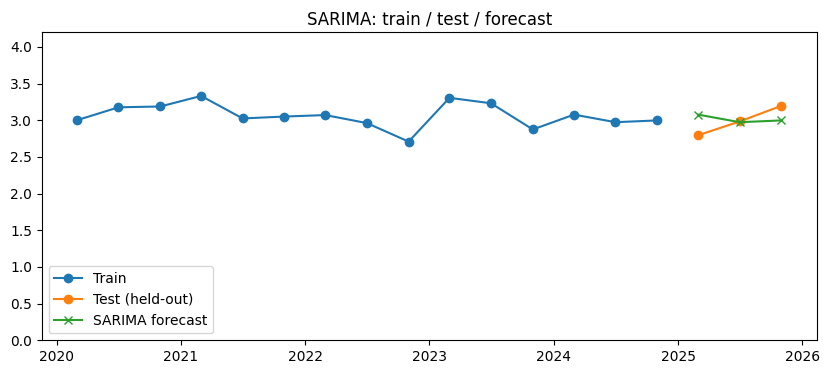

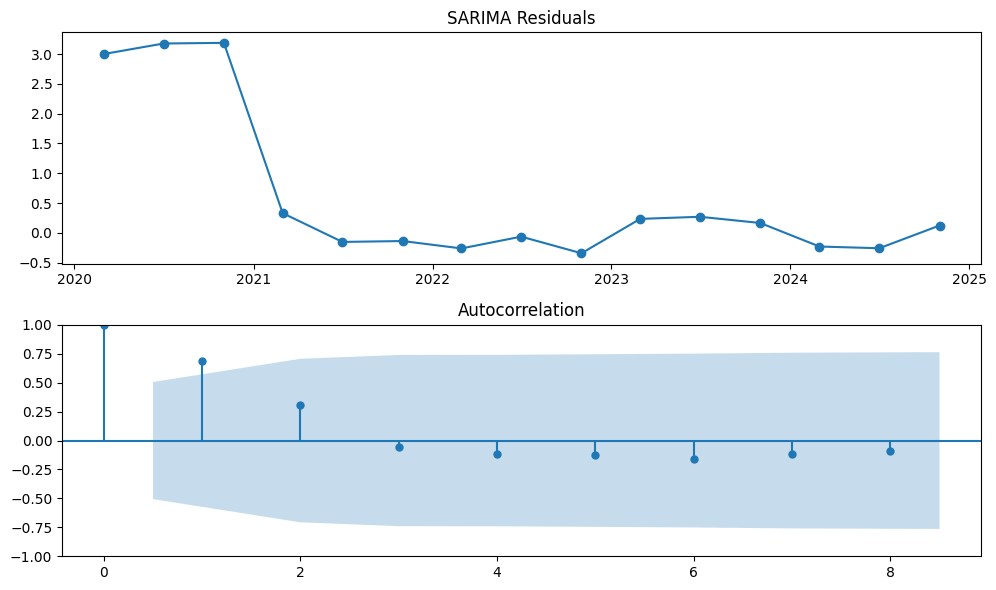

In [ ]:
# 5) SARIMA (seasonal) with seasonal_periods=3
seasonal_periods = 3
# Try to use simple seasonal order, or auto if pmdarima available
if HAS_PMD:
    try:
        auto_s = auto_arima(train, seasonal=True, m=seasonal_periods, stepwise=True, suppress_warnings=True, error_action='ignore', max_p=3, max_q=3, max_P=2, max_Q=2)
        order_sarima = auto_s.order
        seasonal_order = auto_s.seasonal_order
        print("\nauto_arima (seasonal) suggested:", order_sarima, seasonal_order)
    except Exception as e:
        order_sarima = (1,1,1)
        seasonal_order = (1,1,1,seasonal_periods)
        print("auto_arima seasonal failed, using defaults. Error:", e)
else:
    order_sarima = (1,1,1)
    seasonal_order = (1,1,1,seasonal_periods)
    print("\nUsing SARIMA order:", order_sarima, "seasonal_order:", seasonal_order)

# Fit SARIMAX
try:
    model_sarima = sm.tsa.statespace.SARIMAX(train, order=order_sarima, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    res_sarima = model_sarima.fit(disp=False)
    print("\nSARIMA fitted successfully.")
except Exception as e:
    print("\nSARIMA fitting failed:", e)
    res_sarima = None

# Forecast with SARIMA
fc_sarima = None
metrics_sarima = {'rmse':np.nan, 'mae':np.nan, 'mape':np.nan}
if res_sarima is not None:
    try:
        pred_sarima = res_sarima.get_forecast(steps=test_periods).predicted_mean
        metrics_sarima = evaluate_forecast(test, pred_sarima)
        print("\nSARIMA forecast:\n", pred_sarima)
    except Exception as e:
        print("SARIMA forecast failed:", e)
        fc_sarima = None

# Plot SARIMA
plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, marker='o', label='Train')
plt.plot(test.index, test.values, marker='o', label='Test (held-out)')
if res_sarima is not None:
    try:
        pred_sarima = res_sarima.get_forecast(steps=test_periods).predicted_mean
        plt.plot(pred_sarima.index, pred_sarima.values, marker='x', label='SARIMA forecast')
    except Exception:
        pass
plt.title("SARIMA: train / test / forecast")
plt.ylim(0,4.2)
plt.legend()
plt.show()

# SARIMA residual diagnostics (safe)
if res_sarima is not None:
    resid_s = res_sarima.resid.dropna()
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    plt.plot(resid_s.index, resid_s.values, marker='o')
    plt.title('SARIMA Residuals')
    plt.subplot(212)
    safe_plot_acf(resid_s, plt.gca(), max_lags=8)
    plt.tight_layout()
    plt.show()



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)



Holt-Winters (additive) forecast:
 2025-03-01    3.094509
2025-07-01    3.011124
2025-11-01    2.901296
Freq: 4MS, dtype: float64


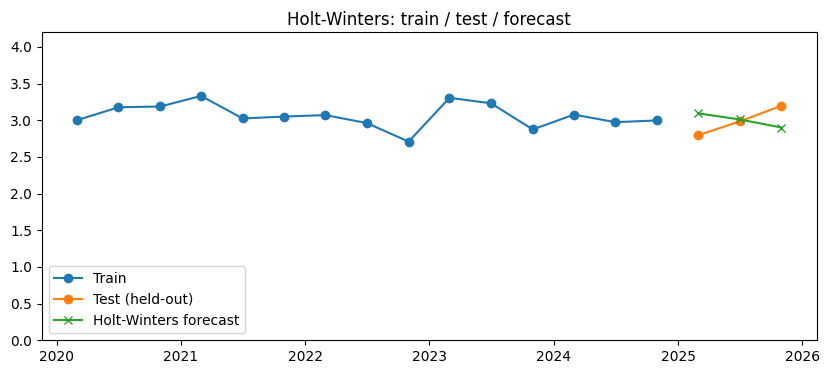

In [ ]:
# 6) Holt-Winters (Exponential Smoothing) with seasonal_periods=3
metrics_hw = {'rmse':np.nan, 'mae':np.nan, 'mape':np.nan}
try:
    hw_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods, initialization_method='estimated').fit(optimized=True)
    pred_hw_add = hw_add.forecast(test_periods)
    metrics_hw = evaluate_forecast(test, pred_hw_add)
    print("\nHolt-Winters (additive) forecast:\n", pred_hw_add)
except Exception as e:
    print("\nHolt-Winters fitting/forecast failed:", e)
    hw_add = None
    pred_hw_add = None

# Plot Holt-Winters
plt.figure(figsize=(10,4))
plt.plot(train.index, train.values, marker='o', label='Train')
plt.plot(test.index, test.values, marker='o', label='Test (held-out)')
if pred_hw_add is not None:
    plt.plot(pred_hw_add.index, pred_hw_add.values, marker='x', label='Holt-Winters forecast')
plt.title("Holt-Winters: train / test / forecast")
plt.ylim(0,4.2)
plt.legend()
plt.show()



In [ ]:
# 7) Compare models using RMSE, MAE, MAPE
results = pd.DataFrame([
    {'model':'ARIMA', 'rmse': metrics_arima['rmse'], 'mae': metrics_arima['mae'], 'mape': metrics_arima['mape']},
    {'model':'SARIMA', 'rmse': metrics_sarima['rmse'], 'mae': metrics_sarima['mae'], 'mape': metrics_sarima['mape']},
    {'model':'Holt-Winters (add)', 'rmse': metrics_hw['rmse'], 'mae': metrics_hw['mae'], 'mape': metrics_hw['mape']}
])

# Display comparison table normally
print("\nModel comparison (Student {})".format(student_id))
display(results.style.format({'rmse': '{:.4f}', 'mae': '{:.4f}', 'mape': '{:.2f}%'}))



Model comparison (Student 1001)


,model,rmse,mae,mape
0,ARIMA,0.1795,0.1611,5.50%
1,SARIMA,0.1992,0.1637,5.55%
2,Holt-Winters (add),0.2435,0.2074,6.95%



Best model by RMSE: ARIMA

Final forecast for next 3 semesters:
2026-03-01    3.053106
2026-07-01    3.053106
2026-11-01    3.053106
Freq: 4MS, Name: predicted_mean, dtype: float64


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4MS will be used.
  self._init_dates(dates, freq)


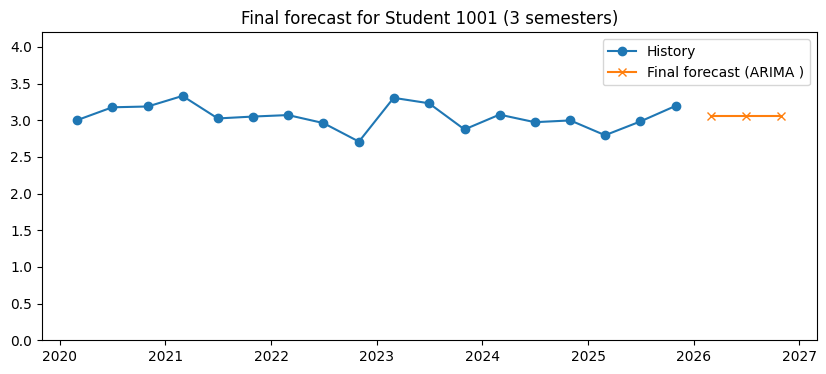

In [ ]:
# 8) Refit best model on full data and forecast next 3 semesters (final forecast)
best_idx = results['rmse'].idxmin()
best_model_name = results.loc[best_idx, 'model']
print("\nBest model by RMSE:", best_model_name)

horizon = 3
final_forecast = None
if best_model_name == 'ARIMA' and res_arima is not None:
    final_model = ARIMA(ts, order=order_arima).fit()
    final_forecast = final_model.get_forecast(steps=horizon).predicted_mean
elif best_model_name == 'SARIMA' and res_sarima is not None:
    final_model = sm.tsa.statespace.SARIMAX(ts, order=order_sarima, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    final_forecast = final_model.get_forecast(steps=horizon).predicted_mean
elif best_model_name.startswith('Holt-Winters') and hw_add is not None:
    hw_final = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=seasonal_periods, initialization_method='estimated').fit(optimized=True)
    final_forecast = hw_final.forecast(horizon)
else:
    # fallback: average of last 3 as naive forecast
    final_forecast = pd.Series([train.iloc[-3:].mean()]*horizon, 
                               index=pd.date_range(start=ts.index[-1] + pd.offsets.DateOffset(months=4), periods=horizon, freq='QS-MAR'))

print("\nFinal forecast for next {} semesters:".format(horizon))
print(final_forecast)

# Plot final forecast on full history
plt.figure(figsize=(10,4))
plt.plot(ts.index, ts.values, marker='o', label='History')
plt.plot(final_forecast.index, final_forecast.values, marker='x', label='Final forecast ({} )'.format(best_model_name))
plt.title(f"Final forecast for Student {student_id} ({horizon} semesters)")
plt.ylim(0,4.2)
plt.legend()
plt.show()
